# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [60]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import re
from IPython.display import display
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [3]:
path = os.path.join(DATA_FOLDER, 'ebola')
guinea_folder = os.path.join(path, 'guinea_data')
liberia_folder = os.path.join(path, 'liberia_data')
sl_folder = os.path.join(path, 'sl_data')
guinea_files = glob.glob(os.path.join(guinea_folder, "*.csv"))
liberia_files = glob.glob(os.path.join(liberia_folder, "*.csv"))
sl_files = glob.glob(os.path.join(sl_folder, "*.csv"))

tmp_df = pd.read_csv(guinea_files[0], usecols=["Date", "Description", "Totals"], parse_dates=['Date'])
tmp_df[tmp_df.Description.str.contains('new') | tmp_df.Description.str.contains('Total deaths')]
df = pd.read_csv(guinea_files[2], parse_dates=['Date'])
df = df.fillna(0)
# df.loc[:, df.columns != 'Date' &]
df = df[(df.Description.str.contains('new cases', case=False) | df.Description.str.contains('deaths', case=False))
   & ~df.Description.str.contains('health workers')]
print(df.loc[:, (df.columns != 'Date') & (df.columns != 'Description') & (df.columns != 'Totals')].astype(int).sum(axis=1))
df

0       5
1       0
2      14
3      19
9       3
10      5
11    162
12    468
13    635
dtype: int64


,Date,Description,Totals,Conakry,Gueckedou,Macenta,Dabola,Kissidougou,Dinguiraye,Telimele,...,Mzerekore,Yomou,Dubreka,Forecariah,Kerouane,Coyah,Dalaba,Beyla,Kindia,Lola
0,2014-09-22,New cases of suspects,5,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1,2014-09-22,New cases of probables,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
2,2014-09-22,New cases of confirmed,14,3,2,7,0,0,0,0,...,0,0,0,0,0,2,0,0.0,0.0,0.0
3,2014-09-22,Total new cases registered so far,19,6,4,7,0,0,0,0,...,0,0,0,0,0,2,0,0.0,0.0,0.0
9,2014-09-22,New deaths registered,3,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
10,2014-09-22,Total deaths of suspects,5,2,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
11,2014-09-22,Total deaths of probables,162,8,111,12,3,5,1,3,...,11,0,0,0,0,0,0,0.0,0.0,0.0
12,2014-09-22,Total deaths of confirmed,468,58,183,161,1,2,0,7,...,9,5,7,7,5,5,0,0.0,0.0,0.0
13,2014-09-22,Total deaths (confirmed + probables + suspects),635,68,295,175,4,7,1,10,...,20,5,7,7,5,5,0,0.0,0.0,0.0


In [4]:
path = os.path.join(DATA_FOLDER, 'ebola')

guinea_folder = os.path.join(path, 'guinea_data')
liberia_folder = os.path.join(path, 'liberia_data')
sl_folder = os.path.join(path, 'sl_data')

guinea_files = glob.glob(os.path.join(guinea_folder, "*.csv"))
liberia_files = glob.glob(os.path.join(liberia_folder, "*.csv"))
sl_files = glob.glob(os.path.join(sl_folder, "*.csv"))
list_df = []
for file in liberia_files:
    df = pd.read_csv(file, usecols=["Date", "Variable", "National"], parse_dates=['Date'])
#     df.Variable.replace('\s+', '_',regex=True,inplace=True)
    list_df.append(df)
df = pd.concat(list_df)
df[(df.Date.dt.month == 8)]
# df_sum = df.groupby([(df.Date.dt.year),(df.Date.dt.month),(df.Variable)]).sum()
# df_sum
# df_sum[np.in1d(df_sum.index.get_level_values(2),['Total death/s in confirmed, probable, suspected cases','Total death/s in confirmed, \n probable, suspected cases'])]
# df_sum[np.in1d(df_sum.index.get_level_values(2),['Total_death/s_in_confirmed,_probable,_suspected_cases'])]

,Date,Variable,National
0,2014-08-25,Specimens collected,4.0
1,2014-08-25,Specimens pending for testing,38.0
2,2014-08-25,Total specimens tested,NaN
3,2014-08-25,Newly reported deaths,28.0
4,2014-08-25,Total death/s in confirmed cases,280.0
5,2014-08-25,Total death/s in probable cases,309.0
6,2014-08-25,Total death/s in suspected cases,182.0
7,2014-08-25,"Total death/s in confirmed, probable, suspecte...",771.0
8,2014-08-25,Case Fatality Rate (CFR) - Confirmed & Probabl...,NaN
9,2014-08-25,Newly reported contacts,151.0


In [5]:
path = os.path.join(DATA_FOLDER, 'ebola')

guinea_folder = os.path.join(path, 'guinea_data')
liberia_folder = os.path.join(path, 'liberia_data')
sl_folder = os.path.join(path, 'sl_data')

guinea_files = glob.glob(os.path.join(guinea_folder, "*.csv"))
liberia_files = glob.glob(os.path.join(liberia_folder, "*.csv"))
sl_files = glob.glob(os.path.join(sl_folder, "*.csv"))

list_df = []
for file in guinea_files:
    df = pd.read_csv(file, usecols=["Date", "Description", "Totals"], parse_dates=['Date'])
    df = df.fillna(0)
    # df.loc[:, df.columns != 'Date' &]
    df = df[(df.Description.str.contains('new cases', case=False)
             | df.Description.str.contains('deaths', case=False)
             | df.Description.str.contains('Cumulative'))
       & ~df.Description.str.contains('health workers')]
    list_df.append(df)
    df.Totals = df.Totals.astype(int)
    df['Country'] = 'Guinea'
    
    
df = pd.concat(list_df)
df[(df.Date.dt.month == 9) & ((df.Description == 'Total new cases registered so far') | (df.Description == 'Cumulative (confirmed + probable + suspects)'))].sort_values(by=['Date', 'Description'])
# df.groupby([(df.Country), (df.Date.dt.year),(df.Date.dt.month),(df.Description)]).sum()
# df.Date.dt.year
# df = pd.read_csv(guinea_files[4], usecols=["Date", "Description", "Totals"], parse_dates=['Date'])
# df = df.fillna(0)
# # df.loc[:, df.columns != 'Date' &]
# df = df[(df.Description.str.contains('new cases', case=False) | df.Description.str.contains('deaths', case=False))
#    & ~df.Description.str.contains('health workers')]
# df

,Date,Description,Totals,Country
7,2014-09-02,Cumulative (confirmed + probable + suspects),790,Guinea
3,2014-09-02,Total new cases registered so far,25,Guinea
7,2014-09-04,Cumulative (confirmed + probable + suspects),823,Guinea
3,2014-09-04,Total new cases registered so far,30,Guinea
7,2014-09-07,Cumulative (confirmed + probable + suspects),861,Guinea
3,2014-09-07,Total new cases registered so far,16,Guinea
7,2014-09-08,Cumulative (confirmed + probable + suspects),861,Guinea
3,2014-09-08,Total new cases registered so far,16,Guinea
7,2014-09-09,Cumulative (confirmed + probable + suspects),867,Guinea
3,2014-09-09,Total new cases registered so far,16,Guinea


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [6]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [7]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## Answer
### Q1
- *pclass*: int ranging from 1 to 3 and can be transformed into a category
- *survived*: we transformed it from an int to a string which can be 'dead' or 'survived', it is a category
- *name*: string
- *sex*: string, female or male and can be transformed into a category
- *age*: float, ranging from 0.17 to 80.0, we kept ages < 1.0 assuming they were babies, e.g. the passenger aged 0.17 would be a 2 month old baby
- *sibsp*: int, ranging from 0 to 8
- *parch*: int, ranging from 0 to 9
- *ticket*: string, mainly with numbers, but also letters, we decided to keep it as strings since the letters could provide additional information
- *fare*: float, ranging from 0.0 to 512.33
- *cabin*: string
- *embarked*: char, C, Q or S, can be transformed into a category
- *boat*: string, mainly numbers, but also sometimes char, we kept it as string since a boat can be either named by a number either by a char.
- *body*: int, ranging from 1 to 328
- *home.dest*: string

In [256]:
df = pd.read_excel(os.path.join(DATA_FOLDER,'titanic.xls'))

df['pclass'] = df.pclass.astype('category')
df.pclass.cat.categories = [1, 2, 3]  

df['survived'] = df.survived.astype('category')
df.survived.cat.categories = ['dead', 'survived']

df['sex'] = df.sex.astype('category')

df['embarked'] = df.embarked.astype('category')

### Q2

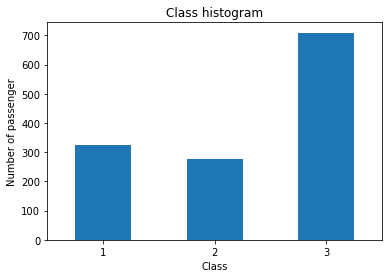

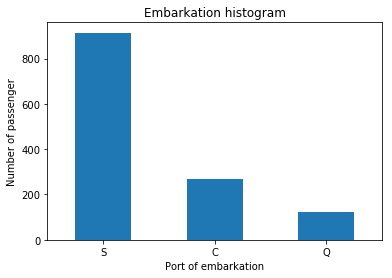

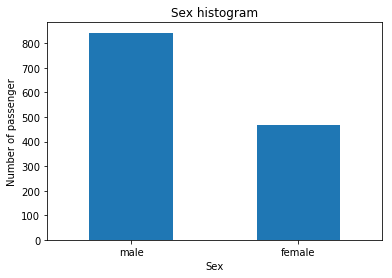

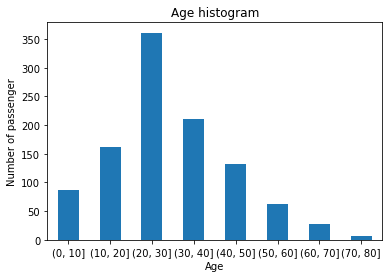

In [82]:
pclass_hist = df.pclass.value_counts().sort_index().plot(kind='bar',title='Class histogram')
pclass_hist.set_xlabel('Class')
pclass_hist.set_ylabel('Number of passenger')
plt.setp(plt.xticks()[1], rotation=0)
plt.show();

embarked_hist = df.embarked.value_counts().sort_index().plot(kind='bar',title='Embarkation histogram')
embarked_hist.set_xlabel('Port of embarkation')
embarked_hist.set_ylabel('Number of passenger')
plt.setp(plt.xticks()[1], rotation=0)
plt.show();

sex_hist = df.sex.value_counts().sort_index().plot(kind='bar',title='Sex histogram')
sex_hist.set_xlabel('Sex')
sex_hist.set_ylabel('Number of passenger')
plt.setp(plt.xticks()[1], rotation=0)
plt.show();

# We cut by age range
age_hist= pd.cut(df.age.dropna(), [0,10,20,30,40,50,60,70,80])\
    .value_counts().sort_index().plot(kind='bar',title='Age histogram')
age_hist.set_xlabel('Age')
age_hist.set_ylabel('Number of passenger')
plt.setp(plt.xticks()[1], rotation=0)
plt.show();

### Q3
We chose to drop all numbers in the cabin and to only keep the last letter for the floor. We had to make this last decision because there were inconsistencies in the data, with cabin such as 'F G63'. We also assumed that if there were several cabin for a group of person, they were all on the same floor thus it does not change our result.

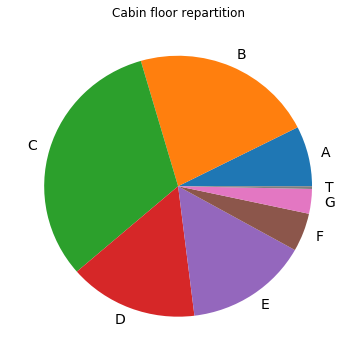

In [269]:
ax = df.cabin.dropna().str.replace('[0-9]*', '')\
    .replace({r'^.*([A-Z])': r'\1'}, regex=True)\
    .value_counts().sort_index().plot(kind='pie',title='Cabin floor repartition', fontsize=14, figsize=(6, 6));
ax.set_ylabel('')
plt.show();

### Q4

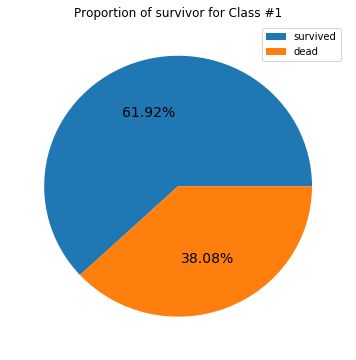

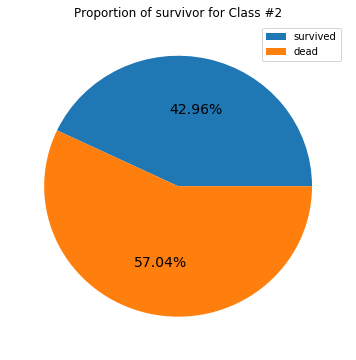

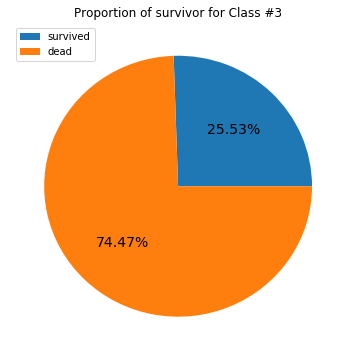

In [136]:
# For each cabin class, we draw a pie
for title, group in df.groupby(df.pclass):
    ax = group.survived.value_counts().sort_index(ascending=False)\
        .plot(kind='pie',title='Proportion of survivor for Class #' + str(title),\
              labels=None,legend=True,autopct='%.2f%%',fontsize=14, figsize=(6, 6))
    ax.set_ylabel('')
    plt.show();

### Q5

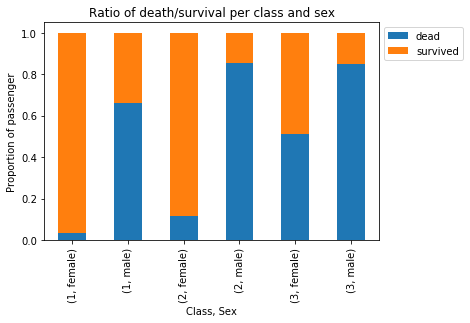

In [281]:
ax = df.groupby([df.pclass, df.sex]).survived.value_counts(normalize=True).unstack('survived')\
    .plot.bar(stacked=True, title='Ratio of death/survival per class and sex');
ax.set_xlabel('Class, Sex')
ax.set_ylabel('Proportion of passenger')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show();

### Q6

In [268]:
# We take only passengers with non NaN ages and sort them by age
df_age = df[df.age.notnull()].sort_values(by='age')
# We split the dataframe in two, assign categories and concatenate it.
df_split = np.array_split(df_age,2)
df_split[0]['age_category'] = 0
df_split[1]['age_category'] = 1
df_age = pd.concat(df_split)
# We group by age category, class and sex, compute the percentage of survival remove the percentage of deaths
# and unstack until we have only one level of index
df_age = df_age.groupby(['age_category','pclass','sex']).survived.value_counts(normalize=True).apply(lambda x: x*100)\
    .unstack().drop('dead', 1).unstack().unstack()
df_age

survived       survived                                                       
sex              female                             male                      
pclass                1          2          3          1          2          3
age_category                                                                  
0             95.121951  90.566038  51.851852  50.000000  22.535211  18.636364
1             96.739130  88.000000  36.363636  31.404959   8.045977  13.953488